## Scroll down and check your arguments before running

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/Deep Learning/github/'
!pwd

/content/drive/My Drive/Deep Learning/github
/content/drive/My Drive/Deep Learning/github


In [3]:
!pip install tensorboardX

In [4]:
!pip install transformers

In [5]:
import os
import json
import time
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from collections import OrderedDict, defaultdict
from matplotlib import pyplot as plt

In [6]:
from ptb import PTB
from utils import to_var, expierment_name
from model import SentenceVAE

In [7]:
import os
import json
import time
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from collections import OrderedDict, defaultdict
from ptb import PTB
from utils import to_var, expierment_name
from model import SentenceVAE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def main(args):
    ts = time.strftime('%Y-%b-%d-%H:%M:%S', time.gmtime())
    t1 = time.time() #starting time

    splits = ['train', 'valid'] + (['test'] if args.test else [])

    datasets = OrderedDict()


    for split in splits:
        datasets[split] = PTB(
            data_dir=args.data_dir,
            split=split,
            create_data=args.create_data,
            max_sequence_length=args.max_sequence_length,
            min_occ=args.min_occ

        )


    params = dict(
        vocab_size=datasets['train'].vocab_size,
        sos_idx=datasets['train'].sos_idx,
        eos_idx=datasets['train'].eos_idx,
        pad_idx=datasets['train'].pad_idx,
        unk_idx=datasets['train'].unk_idx,
        max_sequence_length=args.max_sequence_length,
        embedding_size=args.embedding_size,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        latent_size=args.latent_size,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional
    )
    model = SentenceVAE(**params)

    if torch.cuda.is_available():
        model = model.cuda()

    print(model)
    model_save_folder = "Saved_models"
    dump_folder = "dump"

    if args.tensorboard_logging:
        writer = SummaryWriter(os.path.join(args.logdir, expierment_name(args, ts)))
        writer.add_text("model", str(model))
        writer.add_text("args", str(args))
        writer.add_text("ts", ts)

    #save_model_path = os.path.join(args.save_model_path, ts)
    save_model_path = args.save_model_path + "/" + model_save_folder

    #os.makedirs(save_model_path)
    #os.mkdir(save_model_path)

    with open(os.path.join(save_model_path, 'model_params.json'), 'w') as f:
        json.dump(params, f, indent=4)

    def kl_anneal_function(anneal_function, step, k, x0):
        if anneal_function == 'logistic':
            return float(1/(1+np.exp(-k*(step-x0))))
        elif anneal_function == 'linear':
            return min(1, step/x0)

    NLL = torch.nn.NLLLoss(ignore_index=datasets['train'].pad_idx, reduction='sum')
    NLL_full = torch.nn.NLLLoss(ignore_index=datasets['train'].pad_idx, reduction='none')
    def loss_fn(logp, target, length, mean, logv, anneal_function, step, k, x0):

        # cut-off unnecessary padding from target, and flatten
        target = target[:, :torch.max(length).item()].contiguous().view(-1)
        logp = logp[:, :torch.max(length).item(),:].contiguous().view(-1, logp.size(2))

        # Negative Log Likelihood
        NLL_loss = NLL(logp, target.type(torch.long))

        # KL Divergence
        KL_loss = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp())
        KL_weight = kl_anneal_function(anneal_function, step, k, x0)

        return NLL_loss, KL_loss, KL_weight
    
    def loss_fn_full(logp, target, length, mean, logv):

        # cut-off unnecessary padding from target, and flatten
        target = target[:, :torch.max(length).item()].contiguous().view(-1)
        logp = logp[:, :torch.max(length).item(),:].contiguous().view(-1, logp.size(2))
        # shape (bs*seq_len*vocab)
        # Negative Log Likelihood
        NLL_loss = NLL_full(logp, target.type(torch.long))
        NLL_loss = NLL_loss.view(-1,torch.max(length).item())

        NLL_loss = torch.sum(NLL_loss,1)/length

        KL_loss = -0.5 * (1 + logv - mean.pow(2) - logv.exp())

        return NLL_loss, KL_loss

    def Normplot(val,test,min=False,max=False,n=False):
        if n==False:
            n = int(len(val)/15)
        if min==False:
            min = np.min((val,test))
        if max==False:
            max = np.max((val,test))

        plt.figure(figsize=(12,8))
        bins = np.linspace(min,max,n)
        binwidth = (max+min)/n
        binedges = np.linspace(min-binwidth,max+binwidth,n+1)
        histval,edges = np.histogram(val,binedges)
        histtest,edges = np.histogram(test,binedges)

        erval = np.sqrt(histval)
        erval = erval/np.sum(histval)
        histval = histval/np.sum(histval)
        ertest = np.sqrt(histtest)
        ertest = ertest/np.sum(histtest)
        histtest = histtest/np.sum(histtest)


        plt.bar(bins,histval,yerr=erval,label="Validaiton scores",width=(binedges[-1]-binedges[0])/n,alpha=0.5,color="green")
        plt.bar(bins,histtest,yerr=ertest,label="Test scores",width=(binedges[-1]-binedges[0])/n,alpha=0.3,color="red")
        plt.legend(fontsize='x-large')
        plt.title("score",fontsize='x-large')
        plt.xlabel("NLL-score",fontsize='x-large')
        plt.ylabel("counts(normalized)",fontsize='x-large')
        plt.show()

    def roccurve(val,test,N=50,lin=True):
        val=np.column_stack((val,np.zeros(len(val))))
        test=np.column_stack((test,np.ones(len(test))))
        total=np.append(val,test,axis=0)
        total=total[total[:,0].argsort()]
        nval=np.shape(val)[0]
        ntot=np.shape(total)[0]
        ntest=ntot-nval
        itest=0
        ival=0
        j=0
        testar=[]
        valar=[]

        for i in range(ntot):

            if total[ntot-i-1,1]==1:
                itest+=1
                if itest/ntest>j/N:
                    j=j+1
                    testar+=[itest]
                    valar+=[ival]
                if itest==ntest:
                    break

            else:
                ival+=1

        testar+=[itest]
        valar+=[ival]

        testar=np.array(testar)/ntest
        valar=np.array(valar)/nval

        if lin==True:
            plt.plot(testar,valar,"-")
            plt.xlabel("True positive rate")
            plt.ylabel("False positive rate")
            plt.show()
    
        # print("score:",score,"score2:",sum(valar)*(testar[1]-testar[0]))
        # print("10% true positive gives:",valar[int(N*0.1)], " false positive rate,\n50% true positive gives:",valar[int(N/2)],
        #       " false positive rate,\n 90% true positive gives:", valar[int(N*0.9)], " false positive rate")
        print("10 %% true positive gives: %4.2f %% false positive rate,\n50 %% true positive gives: %4.2f %% false positive rate,\n90 %% true positive rate gives: %4.2f %% false positive rate" % (valar[int(N*0.1)]*100,valar[int(N*0.5)]*100,valar[int(N*0.9)]*100))


    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
    #tensor = torch.cuda.FloatTensor if False else torch.Tensor
    step = 0
    
    lossar_train = np.empty((0,5), float)
    lossar_validation = np.zeros((0,5), float)
    lossar_validation_acum = np.zeros((0,7), float)
    lossar_test = np.zeros((0,5), float)
    lossar_test_acum = np.zeros((0,7), float)
    
    for epoch in range(args.epochs):
        
        NLL_full_val = np.zeros((0,1), float)
        NLL_full_test = np.zeros((0,1), float)
        loss_full_val = np.zeros((0,1), float)
        loss_full_test = np.zeros((0,1), float)

        for split in splits:
            print("\n----- " + split + ", epoch " + str(epoch) + " --------------")
            
            data_loader = DataLoader(
                dataset=datasets[split],
                batch_size=args.batch_size,
                shuffle=split=='train',
                num_workers=cpu_count(),
                pin_memory=torch.cuda.is_available()
            )

            tracker = defaultdict(tensor)

            # Enable/Disable Dropout
            if split == 'train':
                model.train()
            else:
                model.eval()

            for iteration, batch in enumerate(data_loader):

                batch_size = batch['input'].size(0)

                for k, v in batch.items():
                    if torch.is_tensor(v):
                        batch[k] = to_var(v)

                # Forward pass
                logp, mean, logv, z = model(batch['input'], batch['length'])

                # loss calculation
                NLL_loss, KL_loss, KL_weight = loss_fn(logp, batch['target'],
                    batch['length'], mean, logv, args.anneal_function, step, args.k, args.x0)

                loss = (NLL_loss + KL_weight * KL_loss) / batch_size
                loss_norm = loss/torch.sum(batch['length'])*batch_size
                NLL_loss_norm = NLL_loss/torch.sum(batch['length'])*batch_size
                KL_loss_norm = KL_loss.detach().clone()

                
                if not model.training:
                    NLL_lossfull, KL_lossfull = loss_fn_full(logp, batch['target'], batch['length'], mean, logv)
                    if args.plt_total_loss == True:
                        lossfull = (NLL_lossfull + KL_weight * KL_loss)
                    
                # backward + optimization
                if split == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    step += 1
                    lossar_train = np.append(lossar_train,np.array([[len(lossar_train),loss_norm.item(),NLL_loss_norm.item()/batch_size,KL_loss_norm.item()/batch_size,batch_size]]),axis=0)


                # bookkeepeing
                tracker['ELBO'] = torch.cat((tracker['ELBO'], loss.data.view(1, -1)), dim=0)

                if args.tensorboard_logging:
                    writer.add_scalar("%s/ELBO" % split.upper(), loss.item(), epoch*len(data_loader) + iteration)
                    writer.add_scalar("%s/NLL Loss" % split.upper(), NLL_loss.item() / batch_size,
                                      epoch*len(data_loader) + iteration)
                    writer.add_scalar("%s/KL Loss" % split.upper(), KL_loss.item() / batch_size,
                                      epoch*len(data_loader) + iteration)
                    writer.add_scalar("%s/KL Weight" % split.upper(), KL_weight,
                                      epoch*len(data_loader) + iteration)

                if iteration % args.print_every == 0 or iteration+1 == len(data_loader):
                    print("%s Batch %04d/%i, Loss %9.4f, NLL-Loss %9.4f, KL-Loss %9.4f, KL-Weight %6.3f, time passed %6.1f"
                          % (split.upper(), iteration, len(data_loader)-1, loss.item(), NLL_loss.item()/batch_size,
                          KL_loss.item()/batch_size, KL_weight, time.time()-t1))

                if split == 'valid':
                    if 'target_sents' not in tracker:
                        tracker['target_sents'] = list()
                    
                    lossar_validation = np.append(lossar_validation,np.array([[epoch,loss_norm.item(),NLL_loss_norm.item()/batch_size,KL_loss_norm.item()/batch_size,batch_size]]),axis=0)                
                    NLL_full_val = np.append(NLL_full_val,NLL_lossfull.cpu().detach().numpy())
                    if args.plt_total_loss == True:
                        loss_full_val = np.append(loss_full_val,lossfull.cpu().detach().numpy())
                    
                if split == 'test':
                    lossar_test = np.append(lossar_test,np.array([[epoch,loss_norm.item(),NLL_loss_norm.item()/batch_size,KL_loss_norm.item()/batch_size,batch_size]]),axis=0)
                    NLL_full_test = np.append(NLL_full_test,NLL_lossfull.cpu().detach().numpy())
                    if args.plt_total_loss == True:
                        loss_full_test = np.append(loss_full_test,lossfull.cpu().detach().numpy())
                    
                    
            print("%s Epoch %02d/%i, Mean ELBO %9.4f" % (split.upper(), epoch, args.epochs, tracker['ELBO'].mean()))

            if args.tensorboard_logging:
                writer.add_scalar("%s-Epoch/ELBO" % split.upper(), torch.mean(tracker['ELBO']), epoch)

            # save a dump of all sentences and the encoded latent space
            if split == 'valid':
                dump = {'target_sents': tracker['target_sents'], 'z': tracker['z'].tolist()}
                if not os.path.exists(os.path.join('dumps', dump_folder)):
                    os.makedirs('dumps/'+dump_folder)
                with open(os.path.join('dumps/'+dump_folder+'/valid_E%i.json' % epoch), 'w') as dump_file:
                    json.dump(dump,dump_file)
                    
                current=lossar_validation[:,0]==epoch #Epoch,loss,NLL, KL, bs
                nevents=sum(lossar_validation[current,-1])

                loss_mu = np.sum(lossar_validation[current,1:4]*lossar_validation[current,-1][:,None],0)/nevents
                loss_sigma = np.sqrt(sum((lossar_validation[current,-1][:,None]*(lossar_validation[current,1:4]-loss_mu)**2)))/nevents #Uncertainty on mean
                print("Mean of total loss: %4.5f +- %2.5f" % (loss_mu[0], loss_sigma[0])) #Sigma here is uncertainty on mean not std! Multiply by sqrt(nevents) to get std
                print("Mean of NLL loss: %4.5f +- %2.5f" % (loss_mu[1], loss_sigma[1]))
                print("Mean of KL loss: %4.5f +- %2.5f \n" % (loss_mu[2], loss_sigma[2]))

                lossar_validation_acum = np.append(lossar_validation_acum,np.array([[lossar_train[-1,0],loss_mu[0],loss_mu[1],loss_mu[2],
                                                                                     loss_sigma[0],loss_sigma[1],loss_sigma[2]]]),axis=0)

                plt.subplot(131)
                plt.errorbar(lossar_validation_acum[:,0], lossar_validation_acum[:,1], yerr=lossar_validation_acum[:,1+3], label="validation");
                plt.subplot(132)
                plt.errorbar(lossar_validation_acum[:,0], lossar_validation_acum[:,2], yerr=lossar_validation_acum[:,2+3], label="validation");
                plt.subplot(133)
                plt.errorbar(lossar_validation_acum[:,0], lossar_validation_acum[:,3], yerr=lossar_validation_acum[:,3+3], label="validation");
                if not args.test:
                    plt.rc('font', size=16)
                    fig1.text(0.5, 0.94, 'Training, validation and test loss', ha='center');
                    fig1.text(0.5, 0.02, 'batchnumber', ha='center');
                    fig1.text(0.08, 0.5, 'Loss', va='center', rotation='vertical');
                    plt.subplot(131)
                    plt.legend()
                    plt.title("Full loss")
                    plt.subplot(132)
                    plt.legend()
                    plt.title("NLL loss")
                    plt.subplot(133)
                    plt.legend()
                    plt.title("KL loss")
                    plt.show()

                    print("\nKL weight:",KL_weight)             
                    
            if split == 'test':
                current=lossar_test[:,0]==epoch #Epoch,loss,NLL, KL, bs
                nevents=sum(lossar_test[current,-1])

                loss_mu = np.sum(lossar_test[current,1:4]*lossar_test[current,-1][:,None],0)/nevents
                loss_sigma = np.sqrt(sum((lossar_test[current,-1][:,None]*(lossar_test[current,1:4]-loss_mu)**2)))/nevents #Uncertainty on mean
                print("Mean of total loss: %4.5f +- %2.5f" % (loss_mu[0], loss_sigma[0])) #Sigma here is uncertainty on mean not std! Multiply by sqrt(nevents) to get std
                print("Mean of NLL loss: %4.5f +- %2.5f" % (loss_mu[1], loss_sigma[1]))
                print("Mean of KL loss: %4.5f +- %2.5f \n" % (loss_mu[2], loss_sigma[2]))

                lossar_test_acum = np.append(lossar_test_acum,np.array([[lossar_train[-1,0],loss_mu[0],loss_mu[1],loss_mu[2],
                                                                                     loss_sigma[0],loss_sigma[1],loss_sigma[2]]]),axis=0)

                plt.subplot(131)
                plt.errorbar(lossar_test_acum[:,0], lossar_test_acum[:,1], yerr=lossar_test_acum[:,1+3], label="test");
                plt.legend()
                plt.title("Full loss")
                plt.subplot(132)
                plt.errorbar(lossar_test_acum[:,0], lossar_test_acum[:,2], yerr=lossar_test_acum[:,2+3], label="test");
                plt.legend()
                plt.title("NLL loss")
                plt.subplot(133)
                plt.errorbar(lossar_test_acum[:,0], lossar_test_acum[:,3], yerr=lossar_test_acum[:,3+3], label="test");
                plt.legend()
                plt.title("KL loss")
                plt.rc('font', size=16)
                fig1.text(0.5, 0.02, 'batchnumber', ha='center');
                fig1.text(0.08, 0.5, 'Loss', va='center', rotation='vertical');
                print("\nKL weight:",KL_weight)
                plt.show()
                
                NLL_full_val=NLL_full_val[:len(NLL_full_test)]
                NLL_full_test=NLL_full_test[:len(NLL_full_val)]
                Normplot(NLL_full_val,NLL_full_test)

                roccurve(NLL_full_val,NLL_full_test,N=100,lin=True)
                
                if args.plt_total_loss == True:
                    loss_full_val=loss_full_val[:len(loss_full_test)]
                    loss_full_test=loss_full_test[:len(loss_full_val)]
                    Normplot(loss_full_val,loss_full_test)

                    roccurve(loss_full_val,loss_full_test,N=100,lin=True)

            # save checkpoint
            if split == 'train':
                nevents = 0 #I made the formulars to take into account that last batch has different size
                loss_mu = np.array([0,0,0],dtype=float) #And I use last 200 of train (we can change this number) as the model used on the 
                i=0 # first batch is different from the next and so on.
                while nevents<=200:
                    i+=1
                    loss_mu += lossar_train[-i,1:4]*lossar_train[-i,-1]
                    nevents += lossar_train[-i,-1]
                    if i==len(lossar_train):
                        break
                loss_mu = loss_mu/nevents
                # loss_sigma = np.sqrt(sum((lossar[-i:,2]*(lossar[-i:,1]-loss_mu)**2))/nevents)
                loss_sigma = np.sqrt(sum((lossar_train[-i:,-1][:,None]*(lossar_train[-i:,1:4]-loss_mu)**2)))/nevents
                print("Mean loss and uncertainty of 200 last: %4.5f +- %2.5f" % (loss_mu[0], loss_sigma[0])) #Sigma here is uncertainty on mean not std! Multiply by sqrt(nevents) to get std
                print("Mean NLL loss of 200 last: %4.5f +- %2.5f" % (loss_mu[1], loss_sigma[1]))
                print("Mean KL loss of 200 last: %4.5f +- %2.5f" % (loss_mu[2], loss_sigma[2]))

                checkpoint_path = os.path.join(save_model_path, "E%i.pytorch" % epoch)
                torch.save(model.state_dict(), checkpoint_path)
                print("Model saved at %s \n" % checkpoint_path)

                fig1=plt.figure(figsize=(20,5))
                plt.subplot(131)
                plt.plot(lossar_train[:,0],lossar_train[:,1],label="training")
                plt.subplot(132)
                plt.plot(lossar_train[:,0],lossar_train[:,2],label="training")
                plt.subplot(133)
                plt.plot(lossar_train[:,0],lossar_train[:,3],label="training")

In [8]:
parser = argparse.ArgumentParser()

parser.add_argument('--data_dir', type=str, default='data/Dataset')
parser.add_argument('--create_data', action='store_true')
parser.add_argument('--max_sequence_length', type=int, default=30)
parser.add_argument('--min_occ', type=int, default=1) # It's not been used
parser.add_argument('--test', action='store_true')

parser.add_argument('-ep', '--epochs', type=int, default=10)
parser.add_argument('-bs', '--batch_size', type=int, default=32)
parser.add_argument('-lr', '--learning_rate', type=float, default=0.001)

# For BERT pre-trained model hyperparameters check: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json
parser.add_argument('-vs', '--vocab_size', type=int, default=30522) # Cannot be changed for the moment
parser.add_argument('-eb', '--embedding_size', type=int, default=768) # Cannot be changed for the moment
parser.add_argument('-rnn', '--rnn_type', type=str, default='gru')
parser.add_argument('-hs', '--hidden_size', type=int, default=256)
parser.add_argument('-nl', '--num_layers', type=int, default=1)
#parser.add_argument('-bi', '--bidirectional', action='store_true')
parser.add_argument('-bi', '--bidirectional', type=bool, default=True)
parser.add_argument('-ls', '--latent_size', type=int, default=16)
parser.add_argument('-wd', '--word_dropout', type=float, default=0)
parser.add_argument('-ed', '--embedding_dropout', type=float, default=0.5)

parser.add_argument('-af', '--anneal_function', type=str, default='logistic')
parser.add_argument('-k', '--k', type=float, default=0.0025)
parser.add_argument('-x0', '--x0', type=int, default=4000)

parser.add_argument('-v', '--print_every', type=int, default=50)
parser.add_argument('-tb', '--tensorboard_logging', action='store_true')
parser.add_argument('-log', '--logdir', type=str, default='logs')
parser.add_argument('-bin', '--save_model_path', type=str, default='bin')
parser.add_argument('-plt_l', '--plt_total_loss', type=bool, default='True')

_StoreAction(option_strings=['-plt_l', '--plt_total_loss'], dest='plt_total_loss', nargs=None, const=None, default='True', type=<class 'bool'>, choices=None, help=None, metavar=None)

## Here you can modify the arguments

SentenceVAE(
  (embedding_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

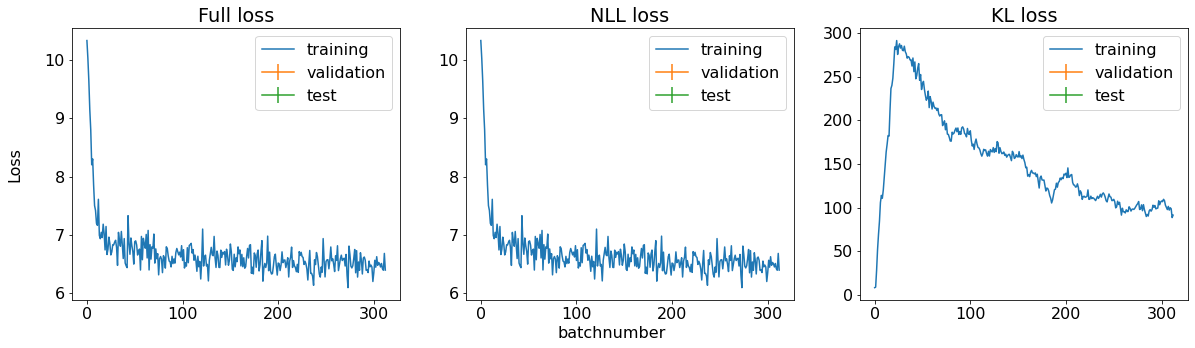

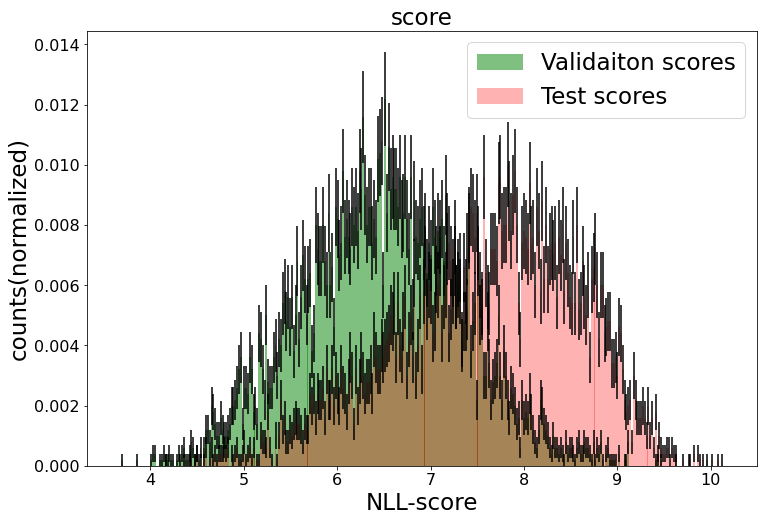

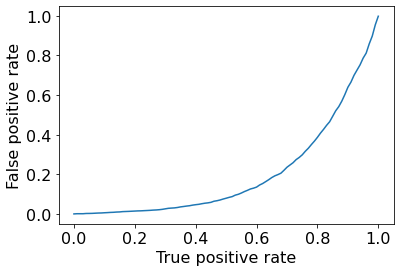

10 % true positive gives: 0.58 % false positive rate,
50 % true positive gives: 7.92 % false positive rate,
90 % true positive rate gives: 63.94 % false positive rate


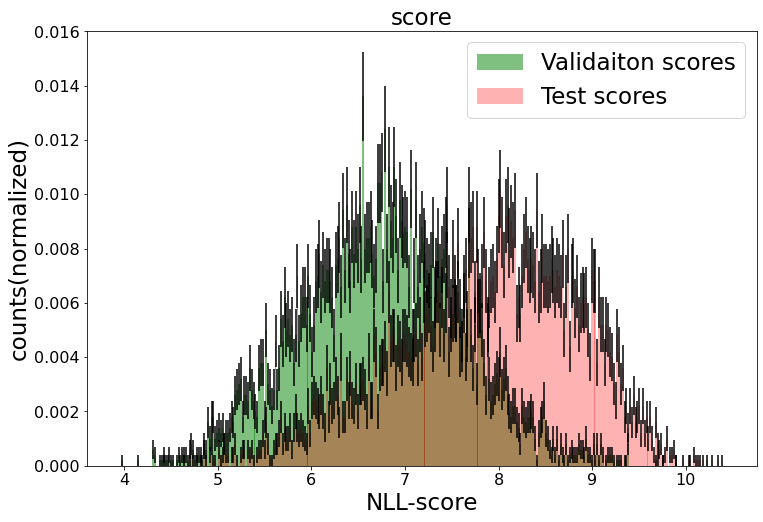

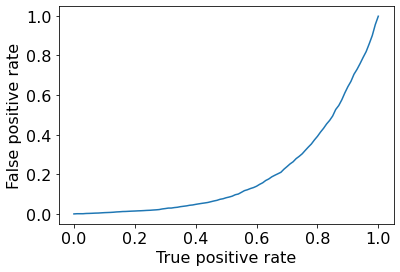

10 % true positive gives: 0.64 % false positive rate,
50 % true positive gives: 8.16 % false positive rate,
90 % true positive rate gives: 64.24 % false positive rate

----- train, epoch 1 --------------
TRAIN Batch 0000/312, Loss   63.5381, NLL-Loss   63.5292, KL-Loss   89.3174, KL-Weight  0.000, time passed  191.1
TRAIN Batch 0050/312, Loss   63.1567, NLL-Loss   63.1448, KL-Loss  105.1265, KL-Weight  0.000, time passed  210.9
TRAIN Batch 0100/312, Loss   72.2228, NLL-Loss   72.2127, KL-Loss   79.4847, KL-Weight  0.000, time passed  230.9
TRAIN Batch 0150/312, Loss   73.4475, NLL-Loss   73.4378, KL-Loss   67.5394, KL-Weight  0.000, time passed  250.8
TRAIN Batch 0200/312, Loss   74.0285, NLL-Loss   74.0185, KL-Loss   61.0781, KL-Weight  0.000, time passed  270.7
TRAIN Batch 0250/312, Loss   69.4527, NLL-Loss   69.4401, KL-Loss   67.9745, KL-Weight  0.000, time passed  290.5
TRAIN Batch 0300/312, Loss   74.9893, NLL-Loss   74.9762, KL-Loss   62.0988, KL-Weight  0.000, time passed  310.

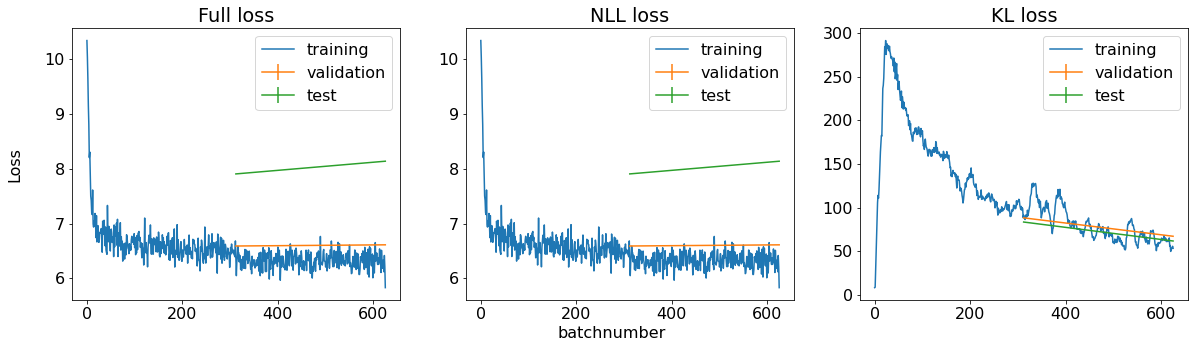

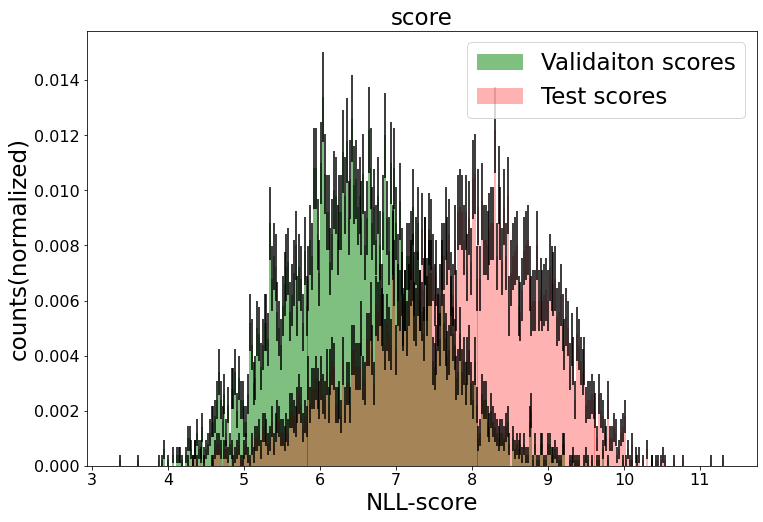

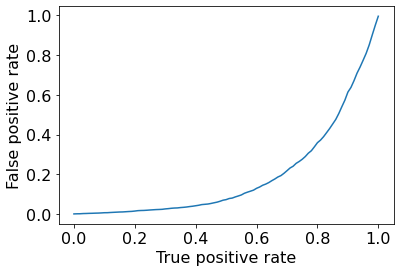

10 % true positive gives: 0.60 % false positive rate,
50 % true positive gives: 7.20 % false positive rate,
90 % true positive rate gives: 61.38 % false positive rate


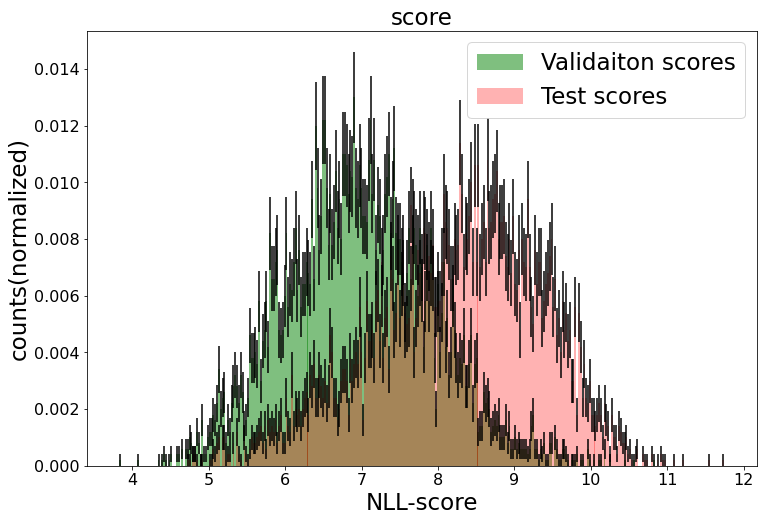

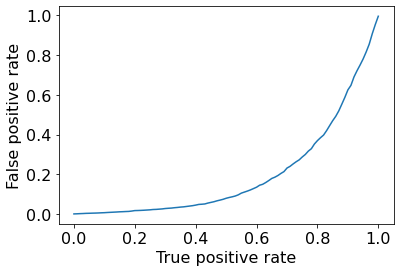

10 % true positive gives: 0.62 % false positive rate,
50 % true positive gives: 7.88 % false positive rate,
90 % true positive rate gives: 62.50 % false positive rate

----- train, epoch 2 --------------
TRAIN Batch 0000/312, Loss   72.0406, NLL-Loss   72.0265, KL-Loss   65.0967, KL-Weight  0.000, time passed  362.6
TRAIN Batch 0050/312, Loss   64.1559, NLL-Loss   64.1378, KL-Loss   73.8823, KL-Weight  0.000, time passed  382.5
TRAIN Batch 0100/312, Loss   73.1813, NLL-Loss   73.1604, KL-Loss   74.7366, KL-Weight  0.000, time passed  402.3
TRAIN Batch 0150/312, Loss   76.5826, NLL-Loss   76.5684, KL-Loss   44.9929, KL-Weight  0.000, time passed  422.1
TRAIN Batch 0200/312, Loss   69.6784, NLL-Loss   69.6601, KL-Loss   51.0633, KL-Weight  0.000, time passed  442.0
TRAIN Batch 0250/312, Loss   71.8275, NLL-Loss   71.8112, KL-Loss   40.1017, KL-Weight  0.000, time passed  461.8
TRAIN Batch 0300/312, Loss   80.6394, NLL-Loss   80.6183, KL-Loss   45.7669, KL-Weight  0.000, time passed  481.

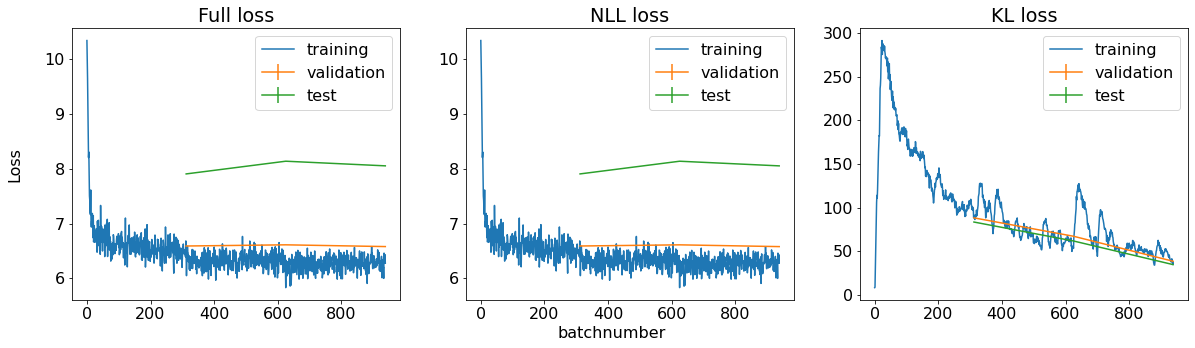

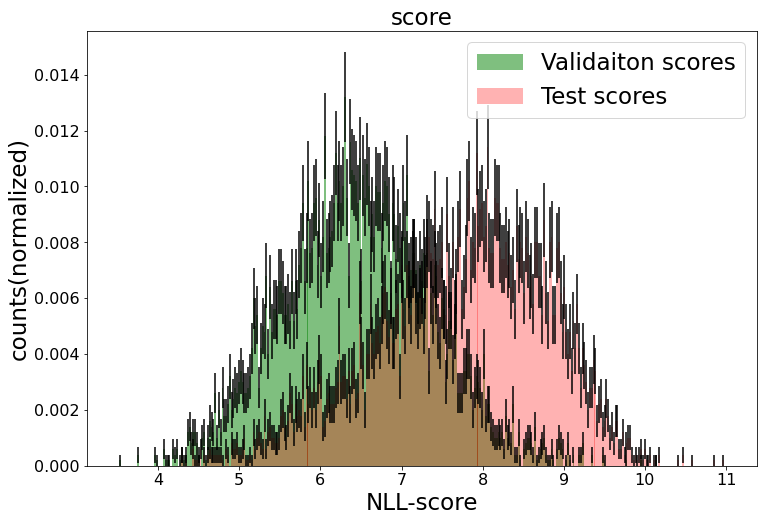

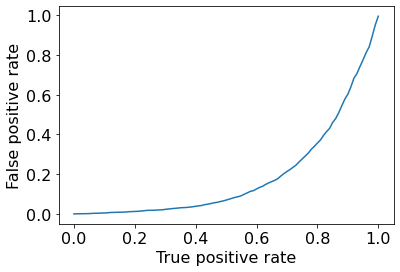

10 % true positive gives: 0.48 % false positive rate,
50 % true positive gives: 6.96 % false positive rate,
90 % true positive rate gives: 60.32 % false positive rate


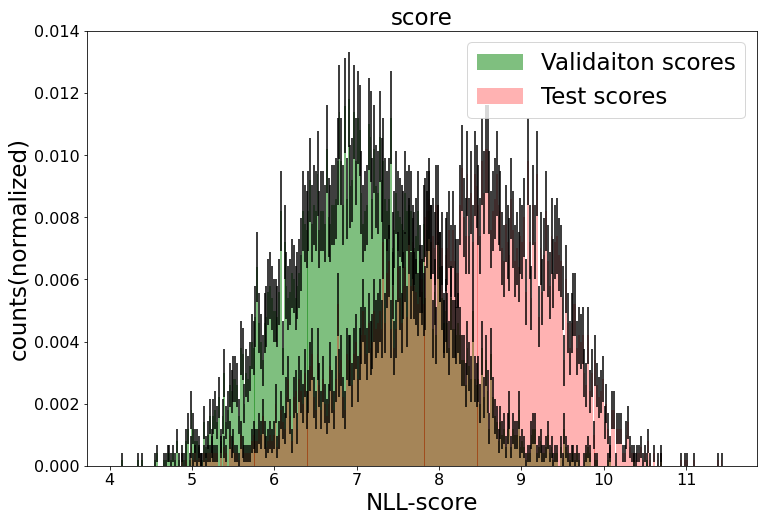

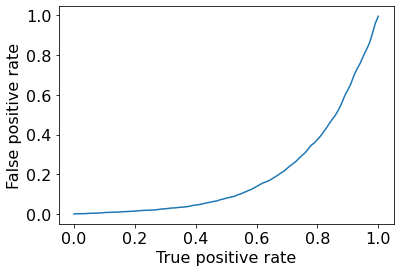

10 % true positive gives: 0.68 % false positive rate,
50 % true positive gives: 7.92 % false positive rate,
90 % true positive rate gives: 62.50 % false positive rate

----- train, epoch 3 --------------
TRAIN Batch 0000/312, Loss   68.5859, NLL-Loss   68.5680, KL-Loss   37.7149, KL-Weight  0.000, time passed  534.0
TRAIN Batch 0050/312, Loss   75.3530, NLL-Loss   75.3272, KL-Loss   47.9442, KL-Weight  0.001, time passed  553.8
TRAIN Batch 0100/312, Loss   73.2113, NLL-Loss   73.1789, KL-Loss   53.0605, KL-Weight  0.001, time passed  573.6
TRAIN Batch 0150/312, Loss   71.6116, NLL-Loss   71.5848, KL-Loss   38.7156, KL-Weight  0.001, time passed  593.5
TRAIN Batch 0200/312, Loss   75.3435, NLL-Loss   75.3155, KL-Loss   35.8145, KL-Weight  0.001, time passed  613.3
TRAIN Batch 0250/312, Loss   73.1224, NLL-Loss   73.0827, KL-Loss   44.7828, KL-Weight  0.001, time passed  633.2
TRAIN Batch 0300/312, Loss   73.2553, NLL-Loss   73.2221, KL-Loss   33.0836, KL-Weight  0.001, time passed  653.

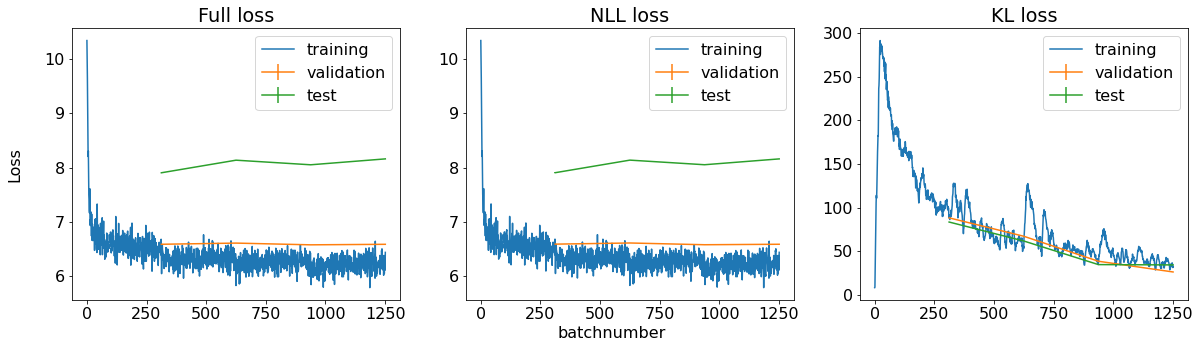

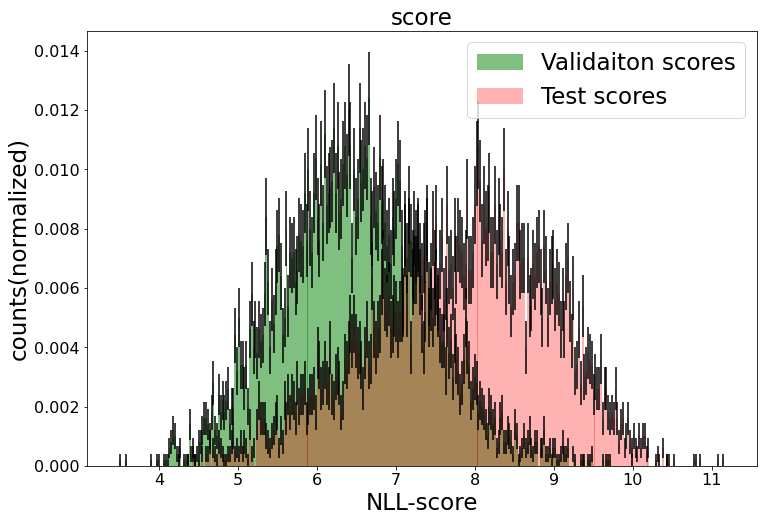

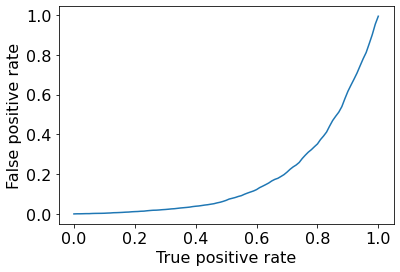

10 % true positive gives: 0.34 % false positive rate,
50 % true positive gives: 6.82 % false positive rate,
90 % true positive rate gives: 61.66 % false positive rate


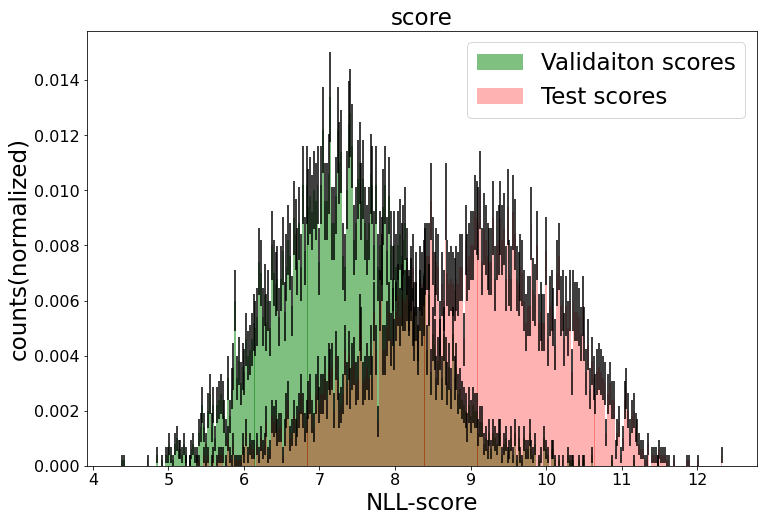

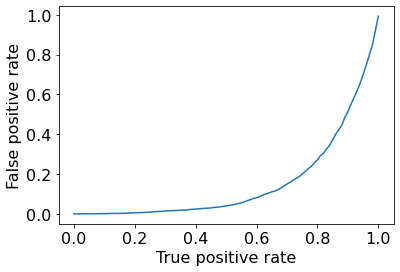

10 % true positive gives: 0.16 % false positive rate,
50 % true positive gives: 4.02 % false positive rate,
90 % true positive rate gives: 51.22 % false positive rate

----- train, epoch 4 --------------
TRAIN Batch 0000/312, Loss   67.4784, NLL-Loss   67.4476, KL-Loss   29.7097, KL-Weight  0.001, time passed  705.3
TRAIN Batch 0050/312, Loss   68.3193, NLL-Loss   68.2818, KL-Loss   31.8881, KL-Weight  0.001, time passed  725.1
TRAIN Batch 0100/312, Loss   65.7922, NLL-Loss   65.7538, KL-Loss   28.8141, KL-Weight  0.001, time passed  744.9
TRAIN Batch 0150/312, Loss   67.5746, NLL-Loss   67.5216, KL-Loss   35.1176, KL-Weight  0.002, time passed  764.7
TRAIN Batch 0200/312, Loss   78.9082, NLL-Loss   78.8533, KL-Loss   32.1241, KL-Weight  0.002, time passed  784.5
TRAIN Batch 0250/312, Loss   65.2636, NLL-Loss   65.2084, KL-Loss   28.5401, KL-Weight  0.002, time passed  804.3
TRAIN Batch 0300/312, Loss   73.0793, NLL-Loss   73.0169, KL-Loss   28.4499, KL-Weight  0.002, time passed  824.

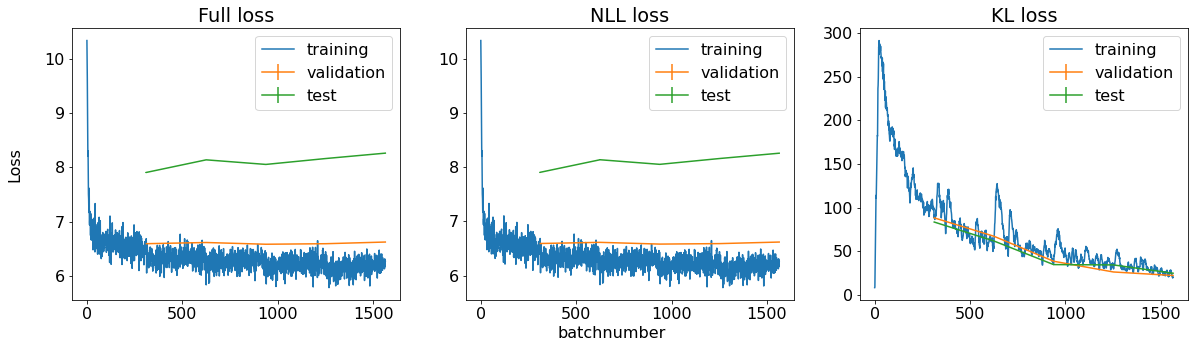

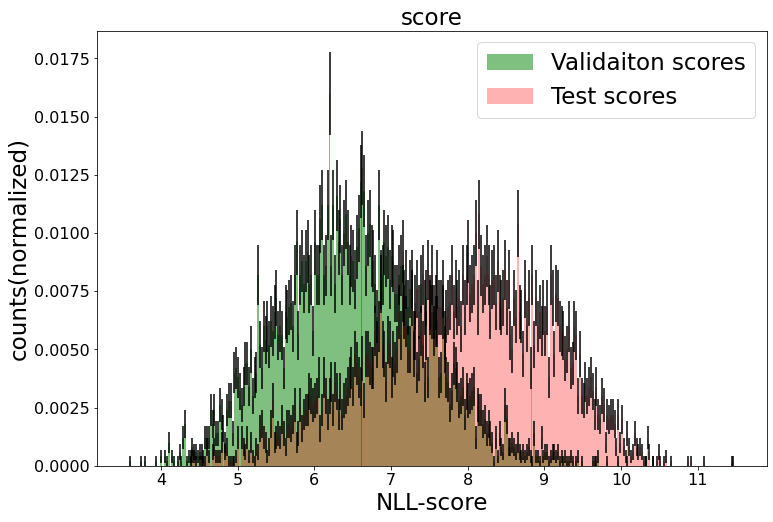

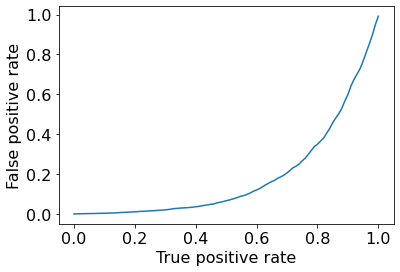

10 % true positive gives: 0.36 % false positive rate,
50 % true positive gives: 6.60 % false positive rate,
90 % true positive rate gives: 59.90 % false positive rate


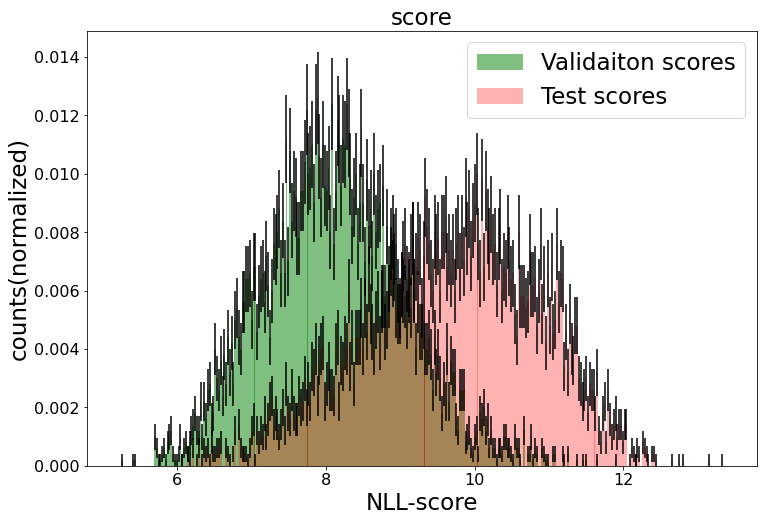

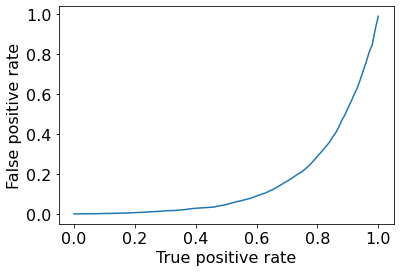

10 % true positive gives: 0.22 % false positive rate,
50 % true positive gives: 4.64 % false positive rate,
90 % true positive rate gives: 53.06 % false positive rate

----- train, epoch 5 --------------
TRAIN Batch 0000/312, Loss   68.8206, NLL-Loss   68.7659, KL-Loss   24.1071, KL-Weight  0.002, time passed  876.5
TRAIN Batch 0050/312, Loss   71.6158, NLL-Loss   71.5380, KL-Loss   30.3239, KL-Weight  0.003, time passed  896.3
TRAIN Batch 0100/312, Loss   61.3010, NLL-Loss   61.2336, KL-Loss   23.1726, KL-Weight  0.003, time passed  916.2
TRAIN Batch 0150/312, Loss   74.2278, NLL-Loss   74.1356, KL-Loss   28.0136, KL-Weight  0.003, time passed  936.0
TRAIN Batch 0200/312, Loss   68.1841, NLL-Loss   68.0929, KL-Loss   24.4332, KL-Weight  0.004, time passed  955.9
TRAIN Batch 0250/312, Loss   67.9538, NLL-Loss   67.8767, KL-Loss   18.2403, KL-Weight  0.004, time passed  975.7
TRAIN Batch 0300/312, Loss   64.6854, NLL-Loss   64.5421, KL-Loss   29.9468, KL-Weight  0.005, time passed  995.

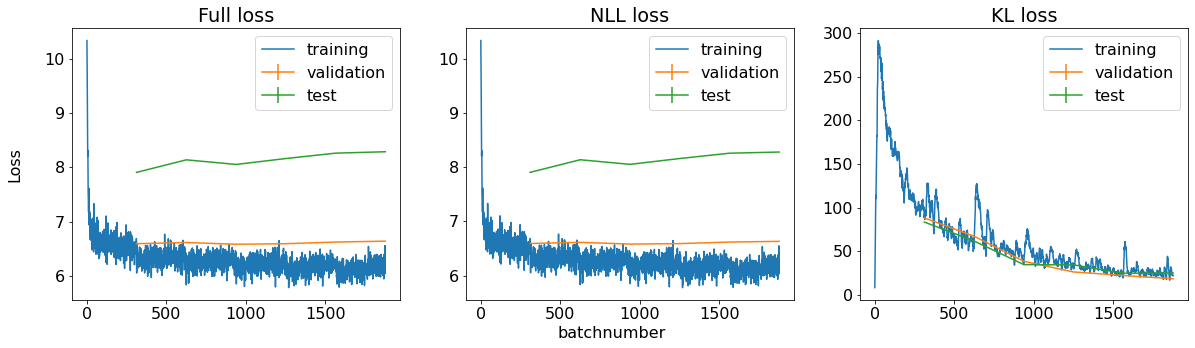

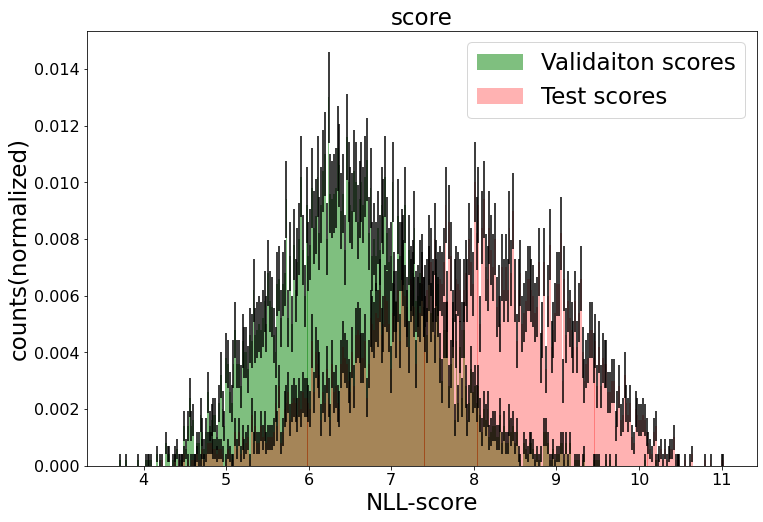

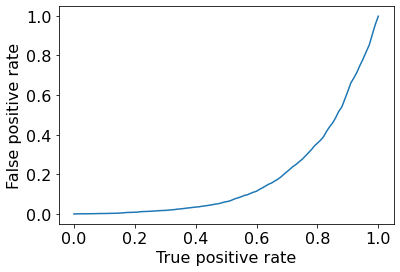

10 % true positive gives: 0.20 % false positive rate,
50 % true positive gives: 6.16 % false positive rate,
90 % true positive rate gives: 62.02 % false positive rate


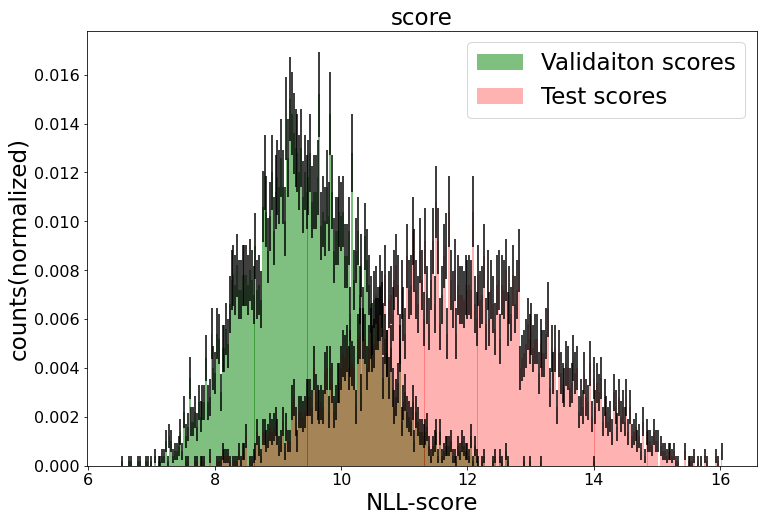

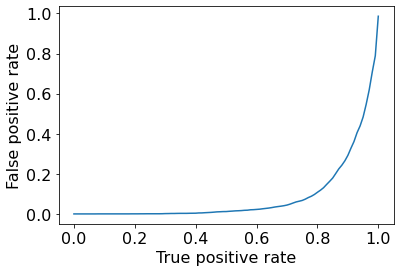

10 % true positive gives: 0.02 % false positive rate,
50 % true positive gives: 1.18 % false positive rate,
90 % true positive rate gives: 29.22 % false positive rate

----- train, epoch 6 --------------
TRAIN Batch 0000/312, Loss   78.5180, NLL-Loss   78.4105, KL-Loss   21.7492, KL-Weight  0.005, time passed 1054.1
TRAIN Batch 0050/312, Loss   72.1379, NLL-Loss   72.0251, KL-Loss   20.1630, KL-Weight  0.006, time passed 1073.9
TRAIN Batch 0100/312, Loss   64.0191, NLL-Loss   63.9106, KL-Loss   17.1216, KL-Weight  0.006, time passed 1093.7
TRAIN Batch 0150/312, Loss   74.9948, NLL-Loss   74.7978, KL-Loss   27.4503, KL-Weight  0.007, time passed 1113.5
TRAIN Batch 0200/312, Loss   73.1249, NLL-Loss   72.9185, KL-Loss   25.4175, KL-Weight  0.008, time passed 1133.3
TRAIN Batch 0250/312, Loss   65.5612, NLL-Loss   65.3599, KL-Loss   21.8905, KL-Weight  0.009, time passed 1153.1
TRAIN Batch 0300/312, Loss   66.4922, NLL-Loss   66.2905, KL-Loss   19.3812, KL-Weight  0.010, time passed 1172.

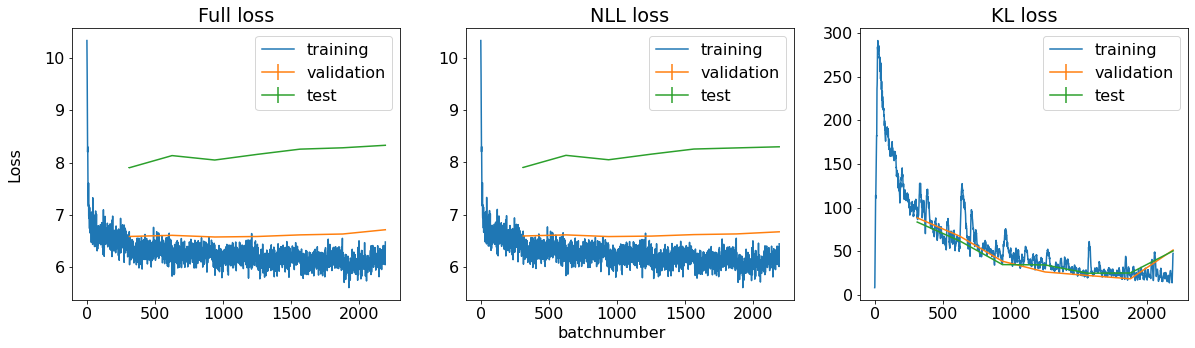

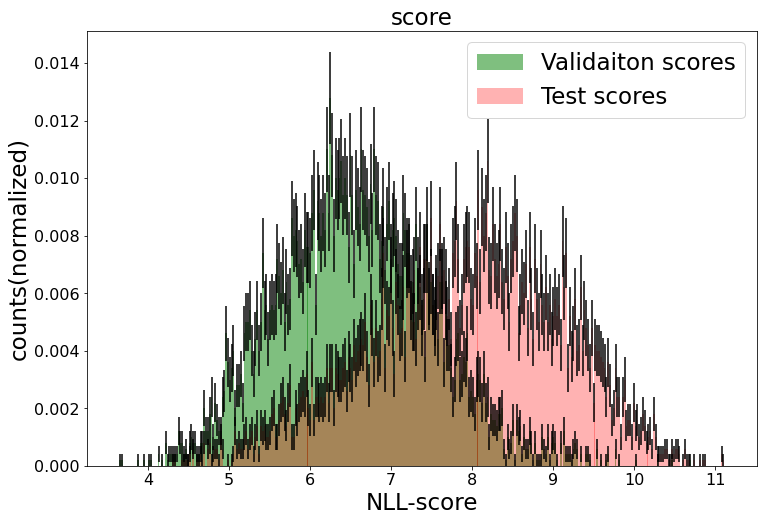

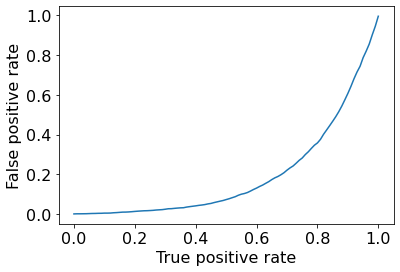

10 % true positive gives: 0.40 % false positive rate,
50 % true positive gives: 7.22 % false positive rate,
90 % true positive rate gives: 60.76 % false positive rate


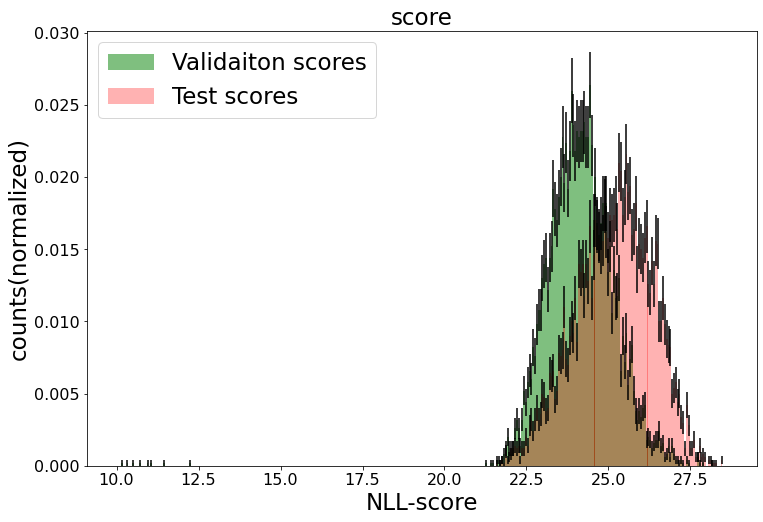

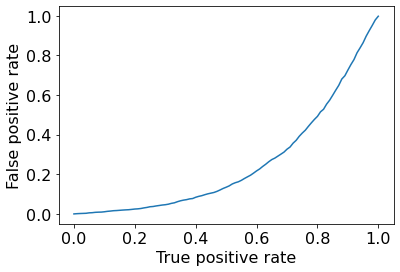

10 % true positive gives: 1.08 % false positive rate,
50 % true positive gives: 13.46 % false positive rate,
90 % true positive rate gives: 72.60 % false positive rate

----- train, epoch 7 --------------
TRAIN Batch 0000/312, Loss   70.6007, NLL-Loss   70.0613, KL-Loss   50.1996, KL-Weight  0.011, time passed 1231.8
TRAIN Batch 0050/312, Loss   59.0234, NLL-Loss   58.8273, KL-Loss   16.1252, KL-Weight  0.012, time passed 1251.6
TRAIN Batch 0100/312, Loss   57.9985, NLL-Loss   57.7899, KL-Loss   15.1671, KL-Weight  0.014, time passed 1271.5
TRAIN Batch 0150/312, Loss   73.1449, NLL-Loss   72.9502, KL-Loss   12.5140, KL-Weight  0.016, time passed 1291.3
TRAIN Batch 0200/312, Loss   67.8698, NLL-Loss   67.6631, KL-Loss   11.7484, KL-Weight  0.018, time passed 1311.2
TRAIN Batch 0250/312, Loss   74.9692, NLL-Loss   74.7282, KL-Loss   12.1157, KL-Weight  0.020, time passed 1331.0
TRAIN Batch 0300/312, Loss   74.1593, NLL-Loss   73.9629, KL-Loss    8.7381, KL-Weight  0.022, time passed 1350

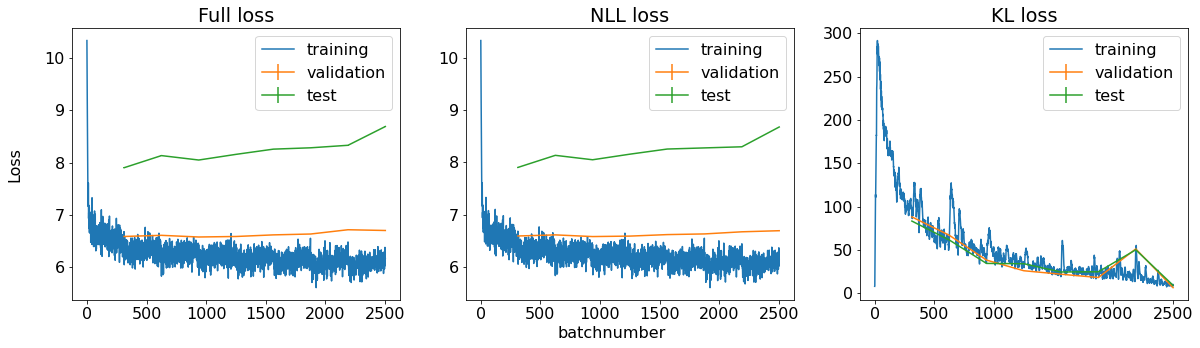

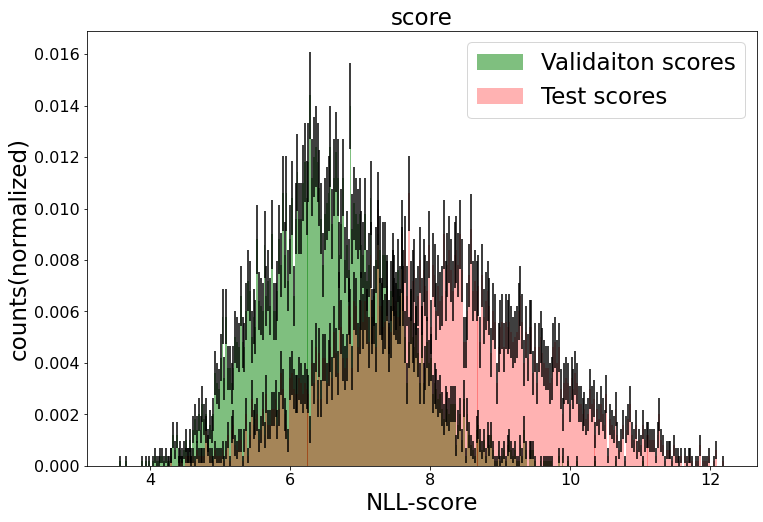

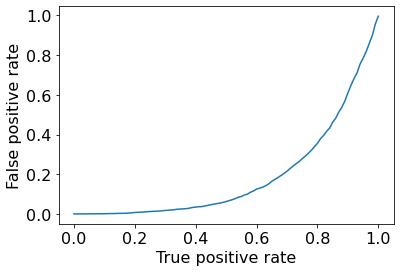

10 % true positive gives: 0.10 % false positive rate,
50 % true positive gives: 6.22 % false positive rate,
90 % true positive rate gives: 60.96 % false positive rate


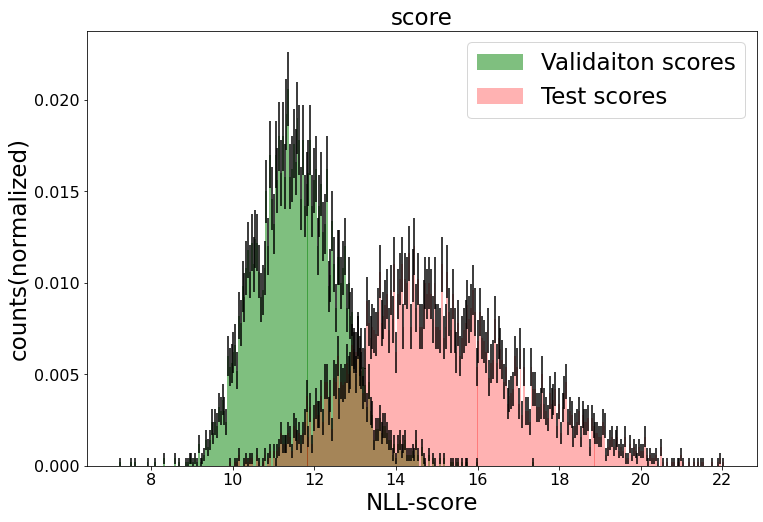

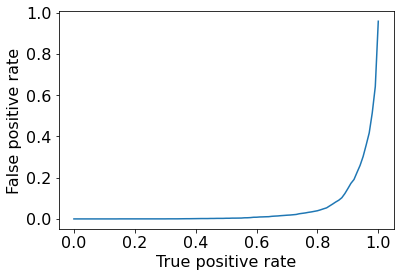

10 % true positive gives: 0.00 % false positive rate,
50 % true positive gives: 0.32 % false positive rate,
90 % true positive rate gives: 14.72 % false positive rate

----- train, epoch 8 --------------
TRAIN Batch 0000/312, Loss   70.2878, NLL-Loss   70.0744, KL-Loss    9.1945, KL-Weight  0.023, time passed 1408.8
TRAIN Batch 0050/312, Loss   69.3684, NLL-Loss   69.0933, KL-Loss   10.4990, KL-Weight  0.026, time passed 1428.7
TRAIN Batch 0100/312, Loss   71.1996, NLL-Loss   70.9833, KL-Loss    7.3077, KL-Weight  0.030, time passed 1448.4
TRAIN Batch 0150/312, Loss   70.9830, NLL-Loss   70.7536, KL-Loss    6.8652, KL-Weight  0.033, time passed 1468.3
TRAIN Batch 0200/312, Loss   73.4636, NLL-Loss   73.2247, KL-Loss    6.3380, KL-Weight  0.038, time passed 1488.1
TRAIN Batch 0250/312, Loss   62.9006, NLL-Loss   62.6347, KL-Loss    6.2577, KL-Weight  0.042, time passed 1507.9
TRAIN Batch 0300/312, Loss   68.6092, NLL-Loss   68.4374, KL-Loss    3.5864, KL-Weight  0.048, time passed 1527.

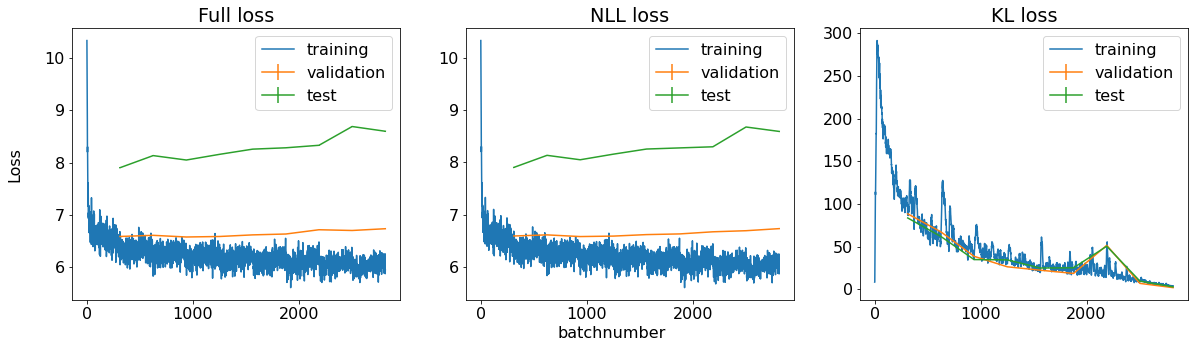

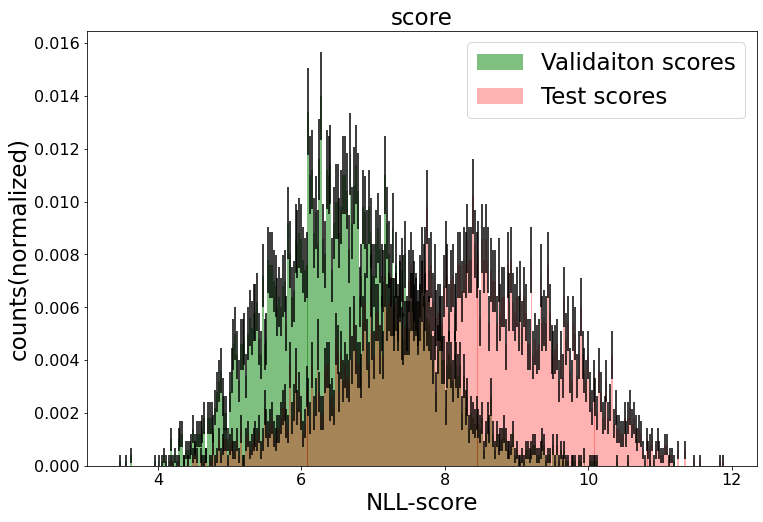

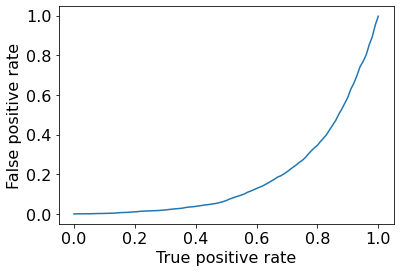

10 % true positive gives: 0.26 % false positive rate,
50 % true positive gives: 6.70 % false positive rate,
90 % true positive rate gives: 58.88 % false positive rate


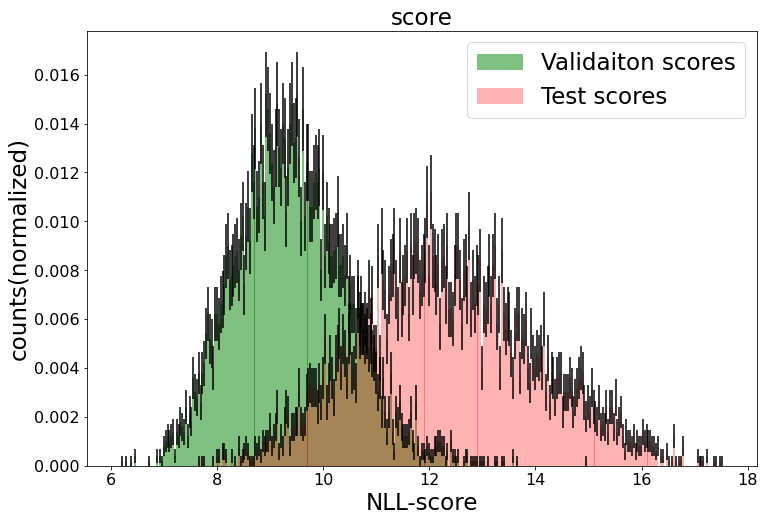

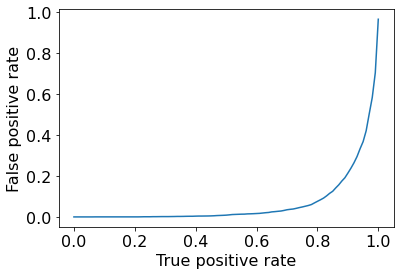

10 % true positive gives: 0.02 % false positive rate,
50 % true positive gives: 0.86 % false positive rate,
90 % true positive rate gives: 21.42 % false positive rate

----- train, epoch 9 --------------
TRAIN Batch 0000/312, Loss   62.4620, NLL-Loss   62.2913, KL-Loss    3.4563, KL-Weight  0.049, time passed 1585.6
TRAIN Batch 0050/312, Loss   59.9897, NLL-Loss   59.8072, KL-Loss    3.2819, KL-Weight  0.056, time passed 1605.5
TRAIN Batch 0100/312, Loss   71.0690, NLL-Loss   70.9024, KL-Loss    2.6638, KL-Weight  0.063, time passed 1625.3
TRAIN Batch 0150/312, Loss   62.1934, NLL-Loss   62.0522, KL-Loss    2.0083, KL-Weight  0.070, time passed 1645.0
TRAIN Batch 0200/312, Loss   71.4390, NLL-Loss   71.2825, KL-Loss    1.9838, KL-Weight  0.079, time passed 1664.9
TRAIN Batch 0250/312, Loss   77.5700, NLL-Loss   77.4403, KL-Loss    1.4667, KL-Weight  0.088, time passed 1684.7
TRAIN Batch 0300/312, Loss   66.7965, NLL-Loss   66.6732, KL-Loss    1.2442, KL-Weight  0.099, time passed 1704.

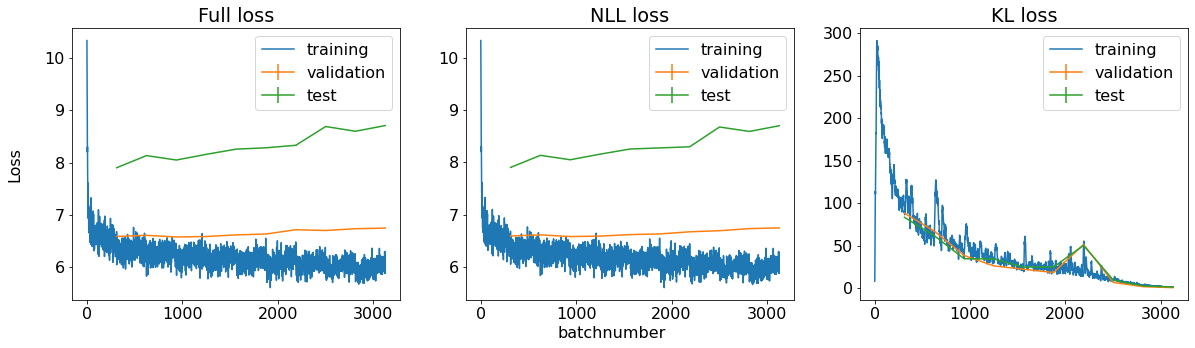

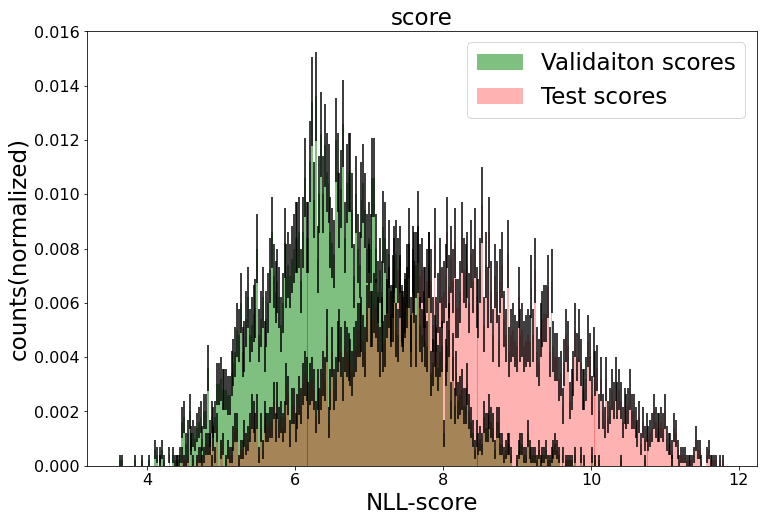

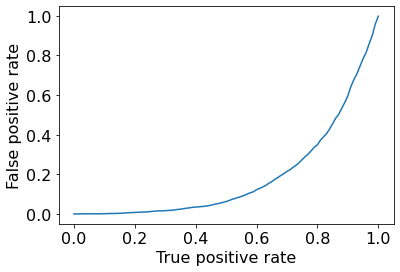

10 % true positive gives: 0.14 % false positive rate,
50 % true positive gives: 6.24 % false positive rate,
90 % true positive rate gives: 59.70 % false positive rate


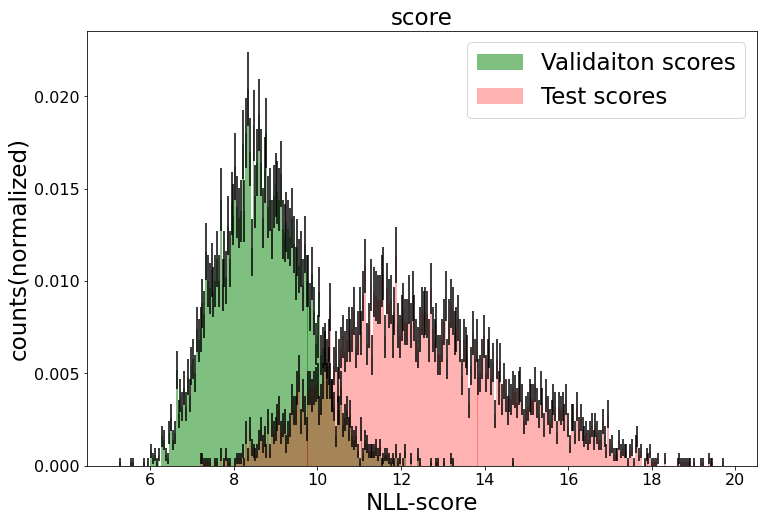

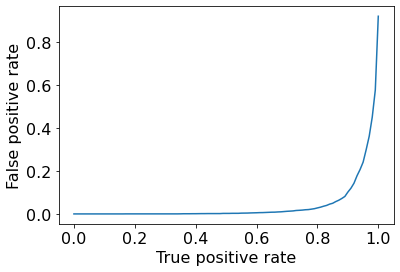

10 % true positive gives: 0.00 % false positive rate,
50 % true positive gives: 0.24 % false positive rate,
90 % true positive rate gives: 10.20 % false positive rate


In [11]:
args = parser.parse_args("--data_dir data/Dataset --max_sequence_length 60 -ep 10 --test".split())

args.rnn_type = args.rnn_type.lower()
args.anneal_function = args.anneal_function.lower()

assert args.rnn_type in ['rnn', 'lstm', 'gru']
assert args.anneal_function in ['logistic', 'linear']
assert 0 <= args.word_dropout <= 1

main(args)

In [10]:
print("Refreshing kernel to keep it alive")

Refreshing kernel to keep it alive
